## Theory

SBI estimates the posterior $p(\theta|x) = {p(\theta)p(x|\theta)}/{p(x)}$ based on samples from the prior $\theta\sim p(\theta)$ and the likelihood $x\sim p(x|\theta)$. Sometimes, we can do both, *sample* and *evaluate* the prior and likelihood. In this case, we can combine the *simulation-based* estimate $q(\theta|x)$ with *likelihood-based* importance sampling, and thereby generate an asymptotically exact estimate for $p(\theta|x)$.

### Importance weights

The main idea is to interpret $q(\theta|x)$ as a proposal distribution and generate proposal samples $\theta_i\sim q(\theta|x)$, and then augment each sample with an importance weight $w_i = p(\theta_i|x) / q(\theta_i|x)$. The definition of the importance weights is motivated from Monte Carlo estimates for the random variable $f(\theta)$, 

$$ 
\mathbb{E}_{\theta\sim p(\theta|x)}\left[f(\theta)\right] 
=\int p(\theta|x) f(\theta)\,\text{d}\theta
\approx \sum_{\theta_i\sim p(\theta_i|x)} f(\theta_i).
$$

We can rewrite this expression as 

$$ 
\mathbb{E}_{\theta\sim p(\theta|x)}\left[f(\theta)\right] 
=\int p(\theta|x) f(\theta)\,\text{d}\theta
=\int q(\theta|x) \frac{p(\theta|x)}{q(\theta|x)}f(\theta)\,\text{d}\theta
\approx \sum_{\theta_i\sim q(\theta_i|x)} \frac{p(\theta_i|x)}{q(\theta_i|x)}f(\theta_i)
\approx \sum_{\theta_i\sim q(\theta_i|x)} w_i\cdot f(\theta_i).
$$

Instead of sampling $\theta_i\sim p(\theta_i|x)$, we can thus sample $\theta_i\sim q(\theta_i|x)$ and attach a corresponding importance weight $w_i$ to each sample. Intuitively, the importance weights downweight samples where $q(\theta|x)$ overestimates $p(\theta|x)$ and upweight samples where $p(\theta|x)$ underestimates $q(\theta|x)$.

### Effective sample size $n_\text{eff}$ and sample efficiency $\epsilon$

If inference were perfect, we would have $w_i = p(\theta_i|x) / q(\theta_i|x) = 1~\forall i$. In practice however, SBI does not provide exact inference results $q(\theta_i|x)$, and the weights will have a finite variance $\text{Var}(w) > 0$. Performing the Monte Carlo estimate above with $n$ samples from $q(\theta|x)$ thus results in reduced precision compared to doing the same with $n$ samples from $p(\theta|x)$. This is formalized by the notion of the *effective sample size* (see e.g. [here](http://www2.stat.duke.edu/~scs/Courses/Stat376/Papers/ConvergeRates/LiuMetropolized1996.pdf))

$$
n_\text{eff} = \frac{n}{1 + \text{Var}(w)} = \frac{\left(\sum_i w_i\right)^2}{\sum_i \left(w_i^2\right)}.
$$

Loosely speaking, using $n$ samples $\theta_i\sim q(\theta_i|x)$ is equivalent to using $n_\text{eff}$ samples from the true posterior $p(\theta|x)$. The *sample efficiency*

$$
\epsilon = \frac{n_\text{eff}}{n} \in (0, 1]
$$

is an indirect measure of the quality of the proposal $q(\theta|x)$.

### Mass coverage
Importance sampling requires $p(\theta|x) \subseteq q(\theta|x)$. When using NPE, this should naturally be ensured, as NPE is trained with the mass-covering forward KL divergence, such that $p(\theta|x) \not\subseteq q(\theta|x)$ for in-distribution data would imply a diverging validation loss. 

When $q(\theta|x)$ is a light-tailed estimate of $p(\theta|x)$, the variance of the importance weights is unbounded and we may encounter a small sample efficiency $\epsilon$.

### Self-normalized importance sampling and the Bayesian evidence

In practice, we don't have access to the normalized posterior, but only to $p(\theta|x) \cdot p(x) = p(\theta)p(x|\theta)$. We thus have to use self-normalized importance sampling. In this case, an unbiased estimate of the Bayesian evidence $p(x)$ can be computed from the normalization of the importance weights (see e.g. [here](https://arxiv.org/abs/2210.05686))

$$
p(x) = \frac{\sum_i w_i}{n}
$$

with a statistical uncertainty scaling with $1/\sqrt{n}$,

$$
\sigma_{p(x)} = p(x)\cdot \sqrt{\frac{1-\epsilon}{n\cdot \epsilon}}.
$$

## Implementation

In [15]:
from torch import ones, eye
import torch
from torch.distributions import MultivariateNormal

from sbi.inference import SNPE, ImportanceSamplingPosterior
from sbi.utils import BoxUniform
from sbi.inference.potentials.base_potential import BasePotential
from sbi.analysis import pairplot, marginal_plot

In [16]:
class Simulator:
    def __init__(self):
        pass

    def log_prob(self, theta, x, prior):
        return MultivariateNormal(theta, eye(2)).log_prob(x) + prior.log_prob(theta)

    def sample(self, theta):
        return theta + torch.randn((theta.shape))

In [17]:
prior = BoxUniform(-5 * ones((2,)), 5 * ones((2,)))
sim = Simulator()

In [18]:
theta = prior.sample((50,))
x = sim.sample(theta)
log_prob = sim.log_prob(theta, x, myprior)

In [6]:
log_prob

tensor([ -7.0203,  -6.7757,  -8.7409, -11.0604,  -6.8828,  -6.8849,  -6.7167,
         -6.5307,  -7.6620,  -7.1050,  -6.9813,  -7.7949,  -6.4848,  -8.8385,
         -6.5047,  -7.5428,  -6.5311,  -7.8525,  -7.6094,  -6.8969,  -6.5591,
         -8.4800,  -9.2732,  -7.5526,  -6.8612,  -6.9509,  -6.6061,  -6.9288,
         -8.6525,  -6.8885,  -9.0233,  -6.6701,  -6.9285, -11.2049,  -6.5632,
         -6.6593,  -7.2530,  -7.5786, -11.1936,  -6.6386,  -6.6733,  -7.0817,
         -6.5013, -10.9662,  -6.8552,  -7.1537,  -7.4354,  -8.6405,  -7.6694,
         -6.6940])

 Neural network successfully converged after 93 epochs.observations.shape torch.Size([5, 2])


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 256 posterior samples:   0%|          | 0/256 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 256 posterior samples:   0%|          | 0/256 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 256 posterior samples:   0%|          | 0/256 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 256 posterior samples:   0%|          | 0/256 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 256 posterior samples:   0%|          | 0/256 [00:00<?, ?it/s]

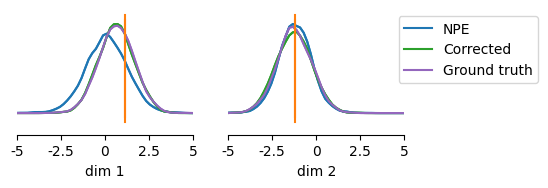

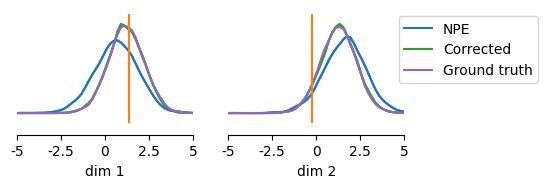

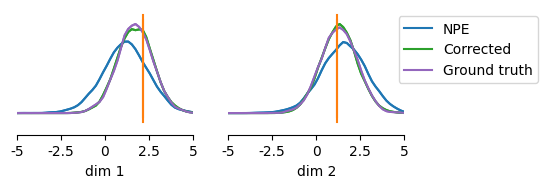

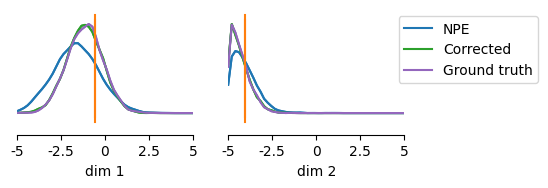

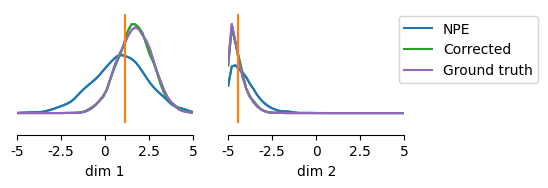

In [1]:
from torch import ones, eye
import torch
from torch.distributions import MultivariateNormal

from sbi.inference import SNPE, ImportanceSamplingPosterior
from sbi.utils import BoxUniform
from sbi.inference.potentials.base_potential import BasePotential
from sbi.analysis import pairplot, marginal_plot


class Simulator:
    def __init__(self):
        pass

    def log_prob(self, theta, x):
        return MultivariateNormal(theta, eye(2)).log_prob(x) + prior.log_prob(theta)

    def sample(self, theta):
        return theta + torch.randn((theta.shape))


class Potential(BasePotential):
    allow_iid_x = False

    def __init__(self, prior, x_o, **kwargs):
        super().__init__(prior, x_o, **kwargs)

    def __call__(self, theta, **kwargs):
        return sim.log_prob(theta, self.x_o)


prior = BoxUniform(-5 * ones((2,)), 5 * ones((2,)))
sim = Simulator()

_ = torch.manual_seed(3)
theta = prior.sample((50,))
x = sim.sample(theta)

_ = torch.manual_seed(4)
inference = SNPE(prior=prior)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

_ = torch.manual_seed(2)
theta_gt = prior.sample((5,))
observations = sim.sample(theta_gt)
print("observations.shape", observations.shape)


oversampling_factor = 128  # higher will be slower but more accurate
n_samples = 5000

non_corrected_samples_for_all_observations = []
corrected_samples_for_all_observations = []
true_samples = []
for obs in observations:
    non_corrected_samples_for_all_observations.append(posterior.set_default_x(obs).sample((n_samples,)))
    corrected_posterior = ImportanceSamplingPosterior(
        potential_fn=Potential(prior=None, x_o=obs),
        proposal=posterior.set_default_x(obs),
        method="sir",
    )
    corrected_samples = corrected_posterior.sample((n_samples,), oversampling_factor=oversampling_factor)
    corrected_samples_for_all_observations.append(corrected_samples)

    gt_samples = MultivariateNormal(obs, eye(2)).sample((n_samples * 5,))
    gt_samples = gt_samples[prior.support.check(gt_samples)][:n_samples]
    true_samples.append(gt_samples)


for i in range(len(observations)):
    fig, ax = marginal_plot(
        [non_corrected_samples_for_all_observations[i], corrected_samples_for_all_observations[i], true_samples[i]], 
        limits=[[-5, 5], [-5, 5]], 
        points=theta_gt[i], 
        figsize=(5, 1.5),
        diag="kde",  # smooth histogram
    )
    ax[0][1].legend(["NPE", "Corrected", "Ground truth"], loc="upper right", bbox_to_anchor=[1.8, 1.0, 0.0, 0.0])

In [ ]:
potential_logprobs = potential_fn(samples)
proposal_logprobs = proposal.log_prob(samples)
log_importance_weights = potential_logprobs - proposal_logprobs

In [7]:
corrected_posterior.method

'sir'

In [2]:
observations

tensor([[ 0.6470, -1.2714],
        [ 1.2079,  1.2723],
        [ 1.7336,  1.2876],
        [-1.1429, -5.3115],
        [ 1.7205, -5.9448]])

In [3]:
posterior.set_default_x(obs).sample((n_samples,))

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

tensor([[ 0.5436, -4.4635],
        [ 0.9399, -4.8755],
        [ 0.7478, -3.8601],
        ...,
        [ 3.1949, -3.7732],
        [ 2.4367, -3.1603],
        [ 0.2160, -4.4788]])

In [9]:
corrected_posterior = ImportanceSamplingPosterior(
    potential_fn=Potential(prior=None, x_o=obs),
    proposal=posterior.set_default_x(obs),
    # method="sir",
    method="importance",
)

In [10]:
oversampling_factor

128

In [14]:
corrected_samples, weights = corrected_posterior.sample((n_samples,), oversampling_factor=oversampling_factor)

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

In [18]:
torch.sum(torch.exp(weights))**2 / torch.sum(torch.exp(weights)**2)

tensor(2356.5281)

In [17]:
torch.mean(torch.exp(weights))

tensor(0.0033)

In [13]:
corrected_samples

(tensor([[ 0.7254, -4.4200],
         [ 0.0597, -4.9532],
         [ 1.5032, -4.4630],
         ...,
         [ 0.2389, -4.5077],
         [ 0.1377, -4.4233],
         [ 1.6937, -4.9443]]),
 tensor([-5.6697, -5.8994, -5.0362,  ..., -6.1128, -6.3228, -4.3970]))

In [ ]:
non_corrected_samples_for_all_observations.append(posterior.set_default_x(obs).sample((n_samples,)))
corrected_posterior = ImportanceSamplingPosterior(
    potential_fn=Potential(prior=None, x_o=obs),
    proposal=posterior.set_default_x(obs),
    method="sir",
)
corrected_samples = corrected_posterior.sample((n_samples,), oversampling_factor=oversampling_factor)
corrected_samples_for_all_observations.append(corrected_samples)

gt_samples = MultivariateNormal(obs, eye(2)).sample((n_samples * 5,))
gt_samples = gt_samples[prior.support.check(gt_samples)][:n_samples]
true_samples.append(gt_samples)